# Wolf, goat and cabbage problem

River crossing puzzle.

In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from enum import Enum
from copy import deepcopy
from pprint import pprint

## Defining the game

In [6]:
class Location(Enum):
    A = 1
    B = 2

class State:
    man = Location.A
    wolf = Location.A
    goat = Location.A
    cabbage = Location.A

    def __init__(self, man, wolf, goat, cabbage):
        self.man = man
        self.wolf = wolf
        self.goat = goat
        self.cabbage = cabbage

    def __eq__(self, other):
        if (
            self.man == other.man
            and self.wolf == other.wolf
            and self.goat == other.goat
            and self.cabbage == other.cabbage
        ):
            return True
        return False

    def __hash__(self):
        return hash((self.man, self.wolf, self.goat, self.cabbage))

    def __str__(self):
        s = ""
        for name, entity in zip(["M", "W", "G", "C"], [self.man, self.wolf, self.goat, self.cabbage]):
            if entity == Location.A:
                s += name
        s += " | "
        for name, entity in zip(["M", "W", "G", "C"], [self.man, self.wolf, self.goat, self.cabbage]):
            if entity == Location.B:
                s += name
        return s


    def __repr__(self):
        s = ""
        for name, entity in zip(["M", "W", "G", "C"], [self.man, self.wolf, self.goat, self.cabbage]):
            if entity == Location.A:
                s += name
        s += " | "
        for name, entity in zip(["M", "W", "G", "C"], [self.man, self.wolf, self.goat, self.cabbage]):
            if entity == Location.B:
                s += name
        return s


Let's first define the start and end state

In [7]:
initial_state = State(Location.A, Location.A, Location.A, Location.A)
goal_state = State(Location.B, Location.B, Location.B, Location.B)

In [8]:
class Graph:
    def __init__(self):
        self.edges = {}

    def neighbors(self, node):
        return self.edges[node]


graph = Graph()

In [9]:
def is_valid(state):
    if state.goat == state.cabbage and state.man != state.goat:
        return False
    if state.wolf == state.goat and state.man != state.wolf:
        return False
    return True


def next_states(state):
    current = state.man
    next = Location.B if state.man == Location.A else Location.A
    moves = []
    # Include the farmer moving by himself
    alone = deepcopy(state)
    alone.man = next
    moves.append(alone)

    for thing in ["goat", "wolf", "cabbage"]:
        if getattr(state, thing) == state.man:
            copy = deepcopy(state)
            setattr(copy, thing, next)
            copy.man = next
            moves.append(copy)

    return moves

In [10]:
# Encode all states into the graph
def encode(state):
    if state == goal_state:
        return
    if state not in graph.edges.keys():
        nodes = next_states(state)
        graph.edges[state] = nodes
        for node in nodes:
            if is_valid(node):
                encode(node)

In [11]:
encode(initial_state)

In [12]:
# Check that graph is encoded
#{MWGC | : [WGC | M, WG | MC, WC | MG, GC | MW],
pprint(graph.edges)

{MWC | G: [WC | MG, C | MWG, W | MGC],
 WC | MG: [MWC | G, MWGC | ],
 C | MWG: [MC | WG, MGC | W, MWC | G],
 MGC | W: [GC | MW, C | MWG, G | MWC],
 G | MWC: [MG | WC, MWG | C, MGC | W],
 MG | WC: [G | MWC,  | MWGC],
 MWGC | : [WGC | M, WC | MG, GC | MW, WG | MC],
 MWG | C: [WG | MC, W | MGC, G | MWC],
 W | MGC: [MW | GC, MWG | C, MWC | G]}


# Show graph

In [13]:
edges = set([])
for k, v in graph.edges.items():
    for e in v:
        edges.add((str(k), str(e)))
edges = list(edges)

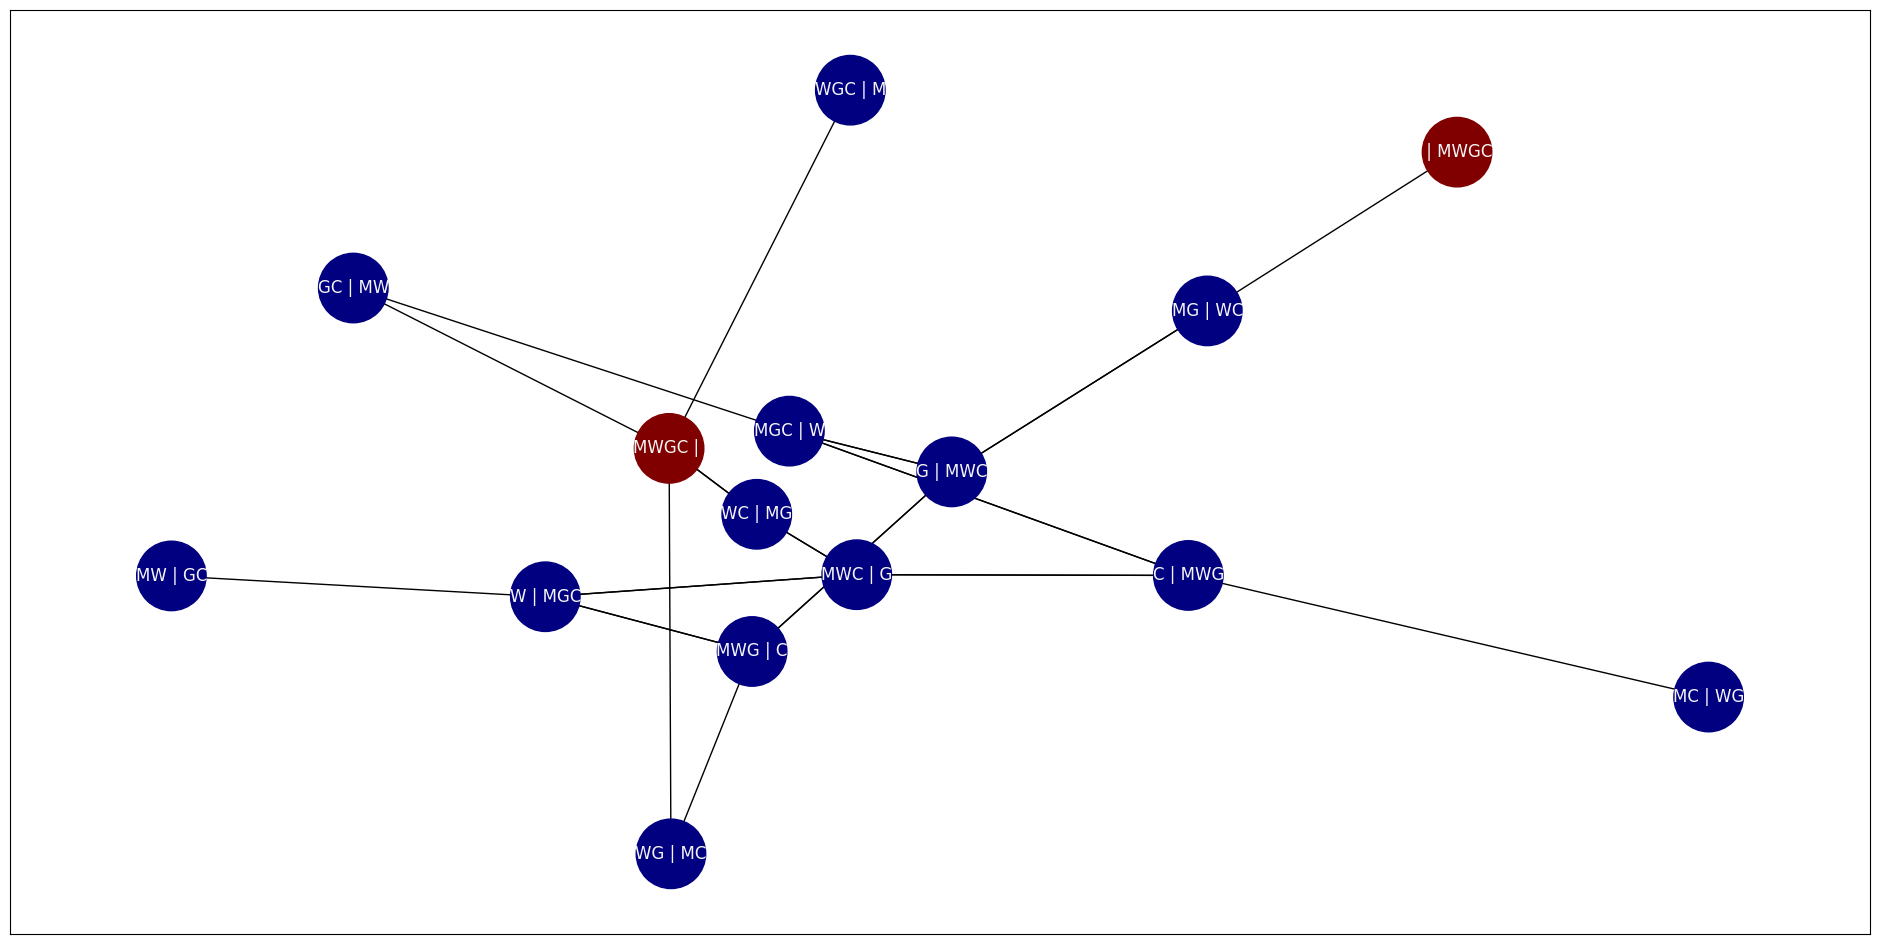

In [14]:
G = nx.DiGraph()
G.add_edges_from(edges)

val_map = {
    'MWGC | ' : 1.0,
    ' | MWGC' : 1.0,
}
values = [val_map.get(node, 0.25) for node in G.nodes()]
f, axes = plt.subplots(1, 1, figsize=(24, 12))

pos = nx.spring_layout(G)
# Draw the circle nodes
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_color=values, node_size = 2500)
# Draw the node labels
nx.draw_networkx_labels(G, pos, font_color='whitesmoke')
nx.draw_networkx_edges(G, pos, edgelist=edges, arrows=False)
plt.show()

# BFS

In [15]:
def bfs(root):
    queue = [[root]]
    visited = set([])
    iterations = 0
    while len(queue) != 0:
        path = queue.pop(0)
        iterations += 1
        node = path[-1]
        if node == goal_state:
            return (iterations, path)
        if node in graph.edges:
            for edge in graph.edges[node]:
                if edge not in visited:
                    visited.add(edge)
                    new_path = list(path)
                    new_path.append(edge)
                    queue.append(new_path)

In [16]:
bfs(initial_state)

(16, [MWGC | , WC | MG, MWC | G, C | MWG, MGC | W, G | MWC, MG | WC,  | MWGC])

With **Breath First Search** we enqueue the next available nodes and explore the frontier nodes with incerasing depth level

# DFS

def dfs(root):
    stack = [[root]]
    visited = set([])
    iterations = 0
    while len(stack) != 0:
        path = stack.pop(len(stack)-1)
        iterations += 1
        node = path[-1]
        visited.add(node)
        if node == goal_state:
            return (iterations, path)
        if node in graph.edges:
            for edge in graph.edges[node]:
                if edge not in visited:
                    visited.add(edge)
                    new_path = list(path)
                    new_path.append(edge)
                    stack.append(new_path)

In [17]:
def dfs(root):
    stack = [[root]]
    visited = set([])
    iterations = 0
    while len(stack) != 0:
        path = stack.pop(len(stack)-1)
        iterations += 1
        node = path[-1]
        visited.add(node)
        if node == goal_state:
            return (iterations, path)
        if node in graph.edges:
            for edge in graph.edges[node]:
                if edge not in visited:
                    visited.add(edge)
                    new_path = list(path)
                    new_path.append(edge)
                    stack.append(new_path)

In [18]:
dfs(initial_state)

(11, [MWGC | , WC | MG, MWC | G, W | MGC, MWG | C, G | MWC, MG | WC,  | MWGC])

With **Depth First Search(DFS)**, we explore each frontier node depth wise. 

As can be seen by the solution cost = 11, it is faster than breath first search

# Constraint forward checking

In [19]:
def constriant_forwardchecking(root):
    stack = [[root]]
    visited = set([])
    iterations = 0
    while len(stack) != 0:
        path = stack.pop(len(stack)-1)
        iterations += 1
        node = path[-1]
        visited.add(node)
        if node == goal_state:
            return (iterations, path)
        if node in graph.edges:
            for edge in graph.edges[node]:
                if edge not in visited and is_valid(edge):
                    visited.add(edge)
                    new_path = list(path)
                    new_path.append(edge)
                    stack.append(new_path)

In [20]:
constriant_forwardchecking(initial_state)

(9, [MWGC | , WC | MG, MWC | G, W | MGC, MWG | C, G | MWC, MG | WC,  | MWGC])

With **constraint forward checking**, we check if the next available nodes are valid states before adding to the frontier for exploration, as seen with the cost=9, we only explored 9 nodes to reach solution 

# Iterative deepening search

In [21]:
def iterative_deepening_search(start_state, goal_state, max_depth):
    nodes_visited = 0

    for depth in range(max_depth):
        result, visited = depth_limited_search(start_state, goal_state, depth)
        nodes_visited = visited
        
        print("Max Depth:", depth, result, "Nodes visited =", nodes_visited)
        if result:
            return result, nodes_visited

    return None, nodes_visited

def depth_limited_search(state, goal_state, depth):
    visited = set()

    return recursive_dls(state, goal_state, depth, visited), len(visited)

def recursive_dls(state, goal_state, depth, visited):
    visited.add(state)

    if state == goal_state:
        return [state]

    if depth == 0:
        return None

    if state in graph.edges:
        for move in graph.edges[state]:
            if move not in visited:
                result = recursive_dls(move, goal_state, depth - 1, visited)
                if result:
                    result.insert(0, state)
                    return result

    return None

In [22]:
iterative_deepening_search(initial_state, goal_state, 9)

Max Depth: 0 None Nodes visited = 1
Max Depth: 1 None Nodes visited = 5
Max Depth: 2 None Nodes visited = 6
Max Depth: 3 None Nodes visited = 8
Max Depth: 4 None Nodes visited = 12
Max Depth: 5 None Nodes visited = 13
Max Depth: 6 None Nodes visited = 14
Max Depth: 7 [MWGC | , WC | MG, MWC | G, C | MWG, MGC | W, G | MWC, MG | WC,  | MWGC] Nodes visited = 11


([MWGC | , WC | MG, MWC | G, C | MWG, MGC | W, G | MWC, MG | WC,  | MWGC], 11)

With **iterative deepening search** we increase the max depth of the breadth first search to a defined cut off. We do this to avoid infinite searching but the **limitation** is that we may not find a solution for a low max depth. This an optimisation technique for BFS in the event the search graph is very **deep**

We can see with a higher depth, we visit more nodes.

# Uniform Cost Search

In [43]:
def ucs(root):
    queue = [(0, [root])]
    visited = set()
    iterations = 0
    while queue:
        queue.sort(key = lambda x: x[0])
        cost, path = queue.pop(0)
        iterations += 1
        node = path[-1]
        if node == goal_state:
            return (iterations, cost, path)
        if node in graph.edges:
            for edge in graph.edges[node]:
                if edge not in visited:
                    visited.add(edge)
                    new_path = list(path)
                    new_path.append(edge)
                    new_cost = cost + 1 
                    queue.append((new_cost, new_path))

In [44]:
ucs(initial_state)

(16,
 7,
 [MWGC | , WC | MG, MWC | G, C | MWG, MGC | W, G | MWC, MG | WC,  | MWGC])